In [3]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.metrics.pairwise import cosine_similarity
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
!pip install git+https://github.com/microsoft/recommenders.git
from recommenders.evaluation.python_evaluation import (
    map, ndcg_at_k, precision_at_k, recall_at_k
)
!gdown https://drive.google.com/uc?id=1vbteMX-kHyYAAS7JIrrog_aZvvOY77Q0

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 2.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

# **Load Dataset**

In [4]:
data = pd.read_csv('final_dataset.csv', dtype = {'Movie': 'string', 'Reviewer': 'string', 'Review': 'string', 'Score': 'float64', 'Sentiment_scores': 'float64', 'overview': 'string', 'recommend': 'int'}, parse_dates=['Date'])
print(data.columns)
print(data.head())

Index(['Movie', 'Reviewer', 'Review', 'Score', 'Sentiment_scores', 'overview',
       'cast_list', 'crew_list', 'director_list', 'first_three_casts',
       'unique_genres', 'Date', 'recommend'],
      dtype='object')
       Movie          Reviewer  \
0  SENSATION   Dennis Schwartz   
1  SENSATION  Carey-Ann Pawsey   
2  SENSATION        Rob Rector   
3  SENSATION        Rich Cline   
4  SENSATION       Allen Adams   

                                              Review     Score  \
0  A sci-fi film that made no sense, as it tells ...  0.686869   
1  A thriller that ultimately makes little to no ...  0.393939   
2  There's still much to admire with Sensation, d...  0.595960   
3  There's no thematic depth in the story or char...  0.494949   
4  Sensation wants to be a deep movie...[but] tho...  0.393939   

   Sentiment_scores                                           overview  \
0          0.276348  Man-boy farmer Donal discovers that his father...   
1          0.334176  Man-boy far

# **Data Processing**

*   create a dataset of unique movies
*   preprocess overview

In [5]:
#keep only unique movies
unique_movies = data.drop_duplicates(subset='Movie')
unique_movies = unique_movies.reset_index()

#preprocess overview
def process_text(text):
    processed_text = ""
    lower_text = text.lower()
    tokenized_text = word_tokenize(lower_text)
    alphabetic_tokens = [token for token in tokenized_text if re.match('^[a-zA-Z]+$', token)]
    lemmatized_words = [WordNetLemmatizer().lemmatize(token) for token in alphabetic_tokens]
    processed_text = ' '.join(lemmatized_words)
    return processed_text

unique_movies['processed_overview'] = unique_movies['overview'].apply(lambda x: process_text(x))




*   convert genres to lower case and combine into 1 string
*   convert director list to lower case, join first and last name, combine into 1 string
*   convert first 3 casts to lower case, join first and last name, combine into 1 string

In [6]:
#convert genres to lowercase and combine into 1 long string
unique_movies['unique_genres'] = unique_movies['unique_genres'].apply(lambda x: eval(x))
unique_movies['processed_genres'] = unique_movies['unique_genres'].apply(lambda x: ' '.join([word.lower() for word in x]))
print(unique_movies['processed_genres'])

#convert director list to lower case, join first and last name, combine into 1 long string
unique_movies['director_list'] = unique_movies['director_list'].apply(lambda x: eval(x))

def process_names(names_list):
  processed_names = [''.join(name.lower().split()) for name in names_list]
  return ' '.join(processed_names)

unique_movies['processed_directors'] = unique_movies['director_list'].apply(lambda x: process_names(x))
print(unique_movies['processed_directors'])

#convert first 3 casts to lower case, join first and last name, combine into 1 long string
unique_movies['first_three_casts'] = unique_movies['first_three_casts'].apply(lambda x: eval(x))
unique_movies['processed_cast'] = unique_movies['first_three_casts'].apply(lambda x: process_names(x))
print(unique_movies['processed_cast'])

0       drama romance comedy foreign
1                  drama history war
2                   thriller mystery
3                             comedy
4             drama thriller mystery
                    ...             
5211                          comedy
5212           drama thriller comedy
5213                        thriller
5214       drama history war foreign
5215                  romance comedy
Name: processed_genres, Length: 5216, dtype: object
0                           tomhall
1                     romanpolanski
2                  wolfgangpetersen
3                      chuckvincent
4                  barbarastepansky
                   ...             
5211    jasonfriedberg aaronseltzer
5212                      henrybean
5213                    chrisjaymes
5214                 enniodeconcini
5215                     carlreiner
Name: processed_directors, Length: 5216, dtype: object
0                luannegordon kellycampbell owenroe
1                jonfinch francescaann

# **Count Vectorizer**

*   Combine processed overview, genres, directors and first 3 casts into one string
*   Create a count vectorizer

In [7]:
#combine overview and genres into 1 long string (soup)
unique_movies['soup'] = unique_movies['processed_overview'] + ' ' + unique_movies['processed_genres'] + ' ' + unique_movies['processed_directors'] + ' ' + unique_movies['processed_cast']
print(unique_movies['soup'][0])

#create a count vectorizer
count_vectorizer = CountVectorizer(analyzer='word', stop_words='english')
count_matrix = count_vectorizer.fit_transform(unique_movies['soup'])

farmer donal discovers that his father ha suddenly passed away now on his own donal attempt to lose his virginity by hiring a prostitute to help him get out of his rut and so he meet kim an aging kiwi escort after engaging in a strictly sexual encounter their relationship soon progress into a lusty romance then to a business enterprise between two partner through these exploit donal and kim provide each other with a sense of love and belonging that neither experienced beforehand drama romance comedy foreign tomhall luannegordon kellycampbell owenroe


# **Bert Model**

*   Combine overview, genres, directors and first 3 casts into one string
*   Create a bert model

In [8]:
#create soup2 for bert
unique_movies['soup2'] = unique_movies['overview'] + ' ' + unique_movies['processed_genres'] + ' ' + unique_movies['processed_directors'] + ' ' + unique_movies['processed_cast']

#create bert model
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')
embeddings = bert_model.encode(unique_movies["soup2"], show_progress_bar=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/163 [00:00<?, ?it/s]

# **Cosine Similarity Scores**

**Create cosine scores for the matrix derived from the count vectorizer and the embedding from the BERT model**

In [9]:
#calculate cosine similarity
cosine_scores = cosine_similarity(count_matrix)
cosine_scores_bert = cosine_similarity(embeddings)

# Flatten the cosine similarity matrix into a 1D array
cosine_scores_flat = cosine_scores.flatten()
cosine_scores_bert_flat = cosine_scores_bert.flatten()

**Compare densities of cosine similarity scores derived from BERT and from count vectorizer**

- Cosine similarity scores derived from BERT will be used in our hybrid model as the distribution is much more even.

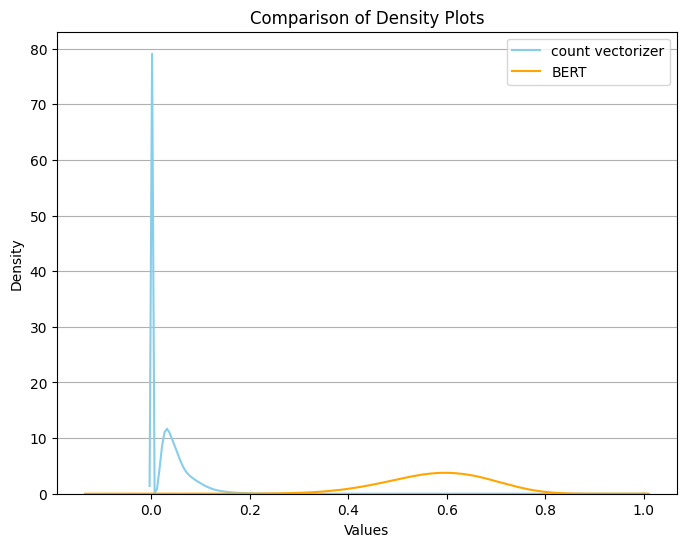

In [10]:
# Plot a density plot
plt.figure(figsize=(8, 6))
sns.kdeplot(cosine_scores_flat, color='skyblue', label='count vectorizer')
sns.kdeplot(cosine_scores_bert_flat, color='orange', label='BERT')
plt.title('Comparison of Density Plots')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y')
plt.show()

# **Preparing training and test sets**

In [11]:
#split data into train and test sets, make sure that only users and items present in train set appear in test set
cf_data = data.loc[:, ['Reviewer', 'Movie', 'Score', 'recommend']]
train, test = train_test_split(cf_data, test_size = 0.15, random_state = 42, shuffle = True)
test = test[test["Reviewer"].isin(train["Reviewer"].unique())]
test = test[test["Movie"].isin(train["Movie"].unique())]

**Determine the threshold for cosine similarity scores to decide whether to recommend or not.**

In [12]:
percentile_90 = np.percentile(cosine_scores_bert_flat, 90)
print(percentile_90)

0.7116745710372925


**Evaluation for Content Based filtering using BERT model**

- Evaluation on Train Set

In [30]:
#find all the liked movies in train set, for all similar movies > threshold, recommend
cbf_train = train[['Reviewer', 'Movie', 'recommend']]
train_liked_movies = cbf_train[cbf_train['recommend'] == 1].drop_duplicates(subset = ['Movie'])['Movie'].tolist()

all_similar_movies = []
for movie in train_liked_movies:
  curr_movie_index = unique_movies.index[unique_movies['Movie'] == movie][0]
  for index, element in enumerate(cosine_scores_bert[curr_movie_index]):
    if (element > percentile_90):
      sim_movie = unique_movies.iloc[index]['Movie']
      all_similar_movies.append(sim_movie)
all_similar_movies = list(set(all_similar_movies))

def assign_value(a):
  if a in all_similar_movies:
    return 1
  else:
    return 0

cbf_train['pred'] = cbf_train['Movie'].apply(lambda x: assign_value(x))

In [31]:
precision_cbf = precision_at_k(rating_pred = cbf_train[['Reviewer', 'Movie', 'pred']], rating_true = cbf_train[['Reviewer', 'Movie', 'recommend']], k = 5, col_user='Reviewer', col_item='Movie', col_rating='recommend', col_prediction = 'pred')
print(f'Precision: {precision_cbf}')

# Recall
recall_cbf = recall_at_k(rating_pred = cbf_train[['Reviewer', 'Movie', 'pred']], rating_true = cbf_train[['Reviewer', 'Movie', 'recommend']], k = 5, col_user='Reviewer', col_item='Movie', col_rating='recommend', col_prediction = 'pred')
print(f'Recall: {recall_cbf}')


#F1 score
f1_cbf = 2 * (precision_cbf * recall_cbf) / (precision_cbf + recall_cbf) if (precision_cbf + recall_cbf) > 0 else 0
print(f'F1 Score: {f1_cbf}')

Precision: 0.6851463521188292
Recall: 0.6384821968541985
F1 Score: 0.6609917085981266


- Evaluation on Test Set

In [32]:
#find all the liked movies in test set, for all similar movies > threshold, recommend
cbf_test = test[['Reviewer', 'Movie', 'recommend']]
test_liked_movies = cbf_test[cbf_test['recommend'] == 1].drop_duplicates(subset = ['Movie'])['Movie'].tolist()

all_similar_movies = []
for movie in test_liked_movies:
  curr_movie_index = unique_movies.index[unique_movies['Movie'] == movie][0]
  for index, element in enumerate(cosine_scores_bert[curr_movie_index]):
    if (element > percentile_90):
      sim_movie = unique_movies.iloc[index]['Movie']
      all_similar_movies.append(sim_movie)
all_similar_movies = list(set(all_similar_movies))

def assign_value(a):
  if a in all_similar_movies:
    return 1
  else:
    return 0

cbf_test['pred'] = cbf_test['Movie'].apply(lambda x: assign_value(x))

In [33]:
precision_cbf = precision_at_k(rating_pred = cbf_test[['Reviewer', 'Movie', 'pred']], rating_true = cbf_test[['Reviewer', 'Movie', 'recommend']], k = 5, col_user='Reviewer', col_item='Movie', col_rating='recommend', col_prediction = 'pred')
print(f'Precision: {precision_cbf}')

# Recall
recall_cbf = recall_at_k(rating_pred = cbf_test[['Reviewer', 'Movie', 'pred']], rating_true = cbf_test[['Reviewer', 'Movie', 'recommend']], k = 5, col_user='Reviewer', col_item='Movie', col_rating='recommend', col_prediction = 'pred')
print(f'Recall: {recall_cbf}')

#F1 score
f1_cbf = 2 * (precision_cbf * recall_cbf) / (precision_cbf + recall_cbf) if (precision_cbf + recall_cbf) > 0 else 0
print(f'F1 Score: {f1_cbf}')


Precision: 0.6667181467181468
Recall: 0.7160752207569212
F1 Score: 0.6905158143267566


**Evaluation for Content Based filtering using Count Vectorizer for cosine similarity**

- Evaluation on Train Set

In [34]:
#find all the liked movies in train set, for all similar movies > threshold, recommend
cbf_train = train[['Reviewer', 'Movie', 'recommend']]
train_liked_movies = cbf_train[cbf_train['recommend'] == 1].drop_duplicates(subset = ['Movie'])['Movie'].tolist()

all_similar_movies = []
for movie in train_liked_movies:
  curr_movie_index = unique_movies.index[unique_movies['Movie'] == movie][0]
  for index, element in enumerate(cosine_scores[curr_movie_index]):
    if (element > percentile_90):
      sim_movie = unique_movies.iloc[index]['Movie']
      all_similar_movies.append(sim_movie)
all_similar_movies = list(set(all_similar_movies))

def assign_value(a):
  if a in all_similar_movies:
    return 1
  else:
    return 0

cbf_train['pred'] = cbf_train['Movie'].apply(lambda x: assign_value(x))

In [35]:
precision_cbf = precision_at_k(rating_pred = cbf_train[['Reviewer', 'Movie', 'pred']], rating_true = cbf_train[['Reviewer', 'Movie', 'recommend']], k = 5, col_user='Reviewer', col_item='Movie', col_rating='recommend', col_prediction = 'pred')
print(f'Precision: {precision_cbf}')

# Recall
recall_cbf = recall_at_k(rating_pred = cbf_train[['Reviewer', 'Movie', 'pred']], rating_true = cbf_train[['Reviewer', 'Movie', 'recommend']], k = 5, col_user='Reviewer', col_item='Movie', col_rating='recommend', col_prediction = 'pred')
print(f'Recall: {recall_cbf}')


#F1 score
f1_cbf = 2 * (precision_cbf * recall_cbf) / (precision_cbf + recall_cbf) if (precision_cbf + recall_cbf) > 0 else 0
print(f'F1 Score: {f1_cbf}')

Precision: 0.6851900393184798
Recall: 0.6384408112274542
F1 Score: 0.6609898588674222


- Evalution on Test Set

In [36]:
#find all the liked movies in test set, for all similar movies > threshold, recommend
cbf_test = test[['Reviewer', 'Movie', 'recommend']]
test_liked_movies = cbf_test[cbf_test['recommend'] == 1].drop_duplicates(subset = ['Movie'])['Movie'].tolist()

all_similar_movies = []
for movie in test_liked_movies:
  curr_movie_index = unique_movies.index[unique_movies['Movie'] == movie][0]
  for index, element in enumerate(cosine_scores[curr_movie_index]):
    if (element > percentile_90):
      sim_movie = unique_movies.iloc[index]['Movie']
      all_similar_movies.append(sim_movie)
all_similar_movies = list(set(all_similar_movies))

def assign_value(a):
  if a in all_similar_movies:
    return 1
  else:
    return 0

cbf_test['pred'] = cbf_test['Movie'].apply(lambda x: assign_value(x))

In [37]:
precision_cbf = precision_at_k(rating_pred = cbf_test[['Reviewer', 'Movie', 'pred']], rating_true = cbf_test[['Reviewer', 'Movie', 'recommend']], k = 5, col_user='Reviewer', col_item='Movie', col_rating='recommend', col_prediction = 'pred')
print(f'Precision: {precision_cbf}')

# Recall
recall_cbf = recall_at_k(rating_pred = cbf_test[['Reviewer', 'Movie', 'pred']], rating_true = cbf_test[['Reviewer', 'Movie', 'recommend']], k = 5, col_user='Reviewer', col_item='Movie', col_rating='recommend', col_prediction = 'pred')
print(f'Recall: {recall_cbf}')

#F1 score
f1_cbf = 2 * (precision_cbf * recall_cbf) / (precision_cbf + recall_cbf) if (precision_cbf + recall_cbf) > 0 else 0
print(f'F1 Score: {f1_cbf}')

Precision: 0.6665637065637066
Recall: 0.7160203421291025
F1 Score: 0.6904074637282777


# **Top-K Recommendations**

In [38]:
#content based filtering method
def recommend_movies(movie, cosine_scores, unique_movies, top_n=5):
    movie_index = unique_movies[unique_movies['Movie'] == movie].index[0]
    sim_scores = list(enumerate(cosine_scores[movie_index]))
    sim_scores.sort(key=lambda x: x[1], reverse=True)

    # Get top n similar movies (excluding the input movie itself)
    top_movies = sim_scores[1:top_n + 1]

    # Extract movie titles from indices
    recommended_movies = [(unique_movies.iloc[i]['Movie'], cosine_scores[movie_index][i]) for i, _ in top_movies]

    return recommended_movies

Recommendations with Count Vectorizer

In [39]:
#test content based filtering
recommended_movies = recommend_movies('INTERSTELLAR', cosine_scores, unique_movies)
print(pd.DataFrame(recommended_movies, columns = ['Movie', 'Cosine_Scores']))

                  Movie  Cosine_Scores
0       PASSAGE TO MARS       0.248734
1          MEGA PIRANHA       0.227921
2  THE SPACE BETWEEN US       0.211100
3      MIDNIGHT SPECIAL       0.211100
4            PROMETHEUS       0.201008


Recommendations with Bert Model

In [40]:
#test content based filtering
recommended_movies = recommend_movies('INTERSTELLAR', cosine_scores_bert, unique_movies)
print(pd.DataFrame(recommended_movies, columns = ['Movie', 'Cosine_Scores_Bert']))

                          Movie  Cosine_Scores_Bert
0                    PROMETHEUS            0.866442
1              STAR TREK BEYOND            0.856962
2               RATCHET & CLANK            0.841057
3       APPROACHING THE UNKNOWN            0.834513
4  ROGUE ONE: A STAR WARS STORY            0.828726
